<a href="https://colab.research.google.com/github/dhirenmalik/CSSE2002/blob/main/COMP37104_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install gdown
# Use the full share link with --fuzzy OR just the file ID between /d/ and /view
LINK = "https://drive.google.com/file/d/1iR_E2j5Td0pzkokWg45yfG_zRsvrHdYp/view?usp=sharing"  # <-- paste your link
!gdown --fuzzy "$LINK" -O /content/oasis.zip
!unzip -q /content/oasis.zip -d /content/OASIS

Downloading...
From (original): https://drive.google.com/uc?id=1iR_E2j5Td0pzkokWg45yfG_zRsvrHdYp
From (redirected): https://drive.google.com/uc?id=1iR_E2j5Td0pzkokWg45yfG_zRsvrHdYp&confirm=t&uuid=6cb4ff58-32ac-438c-a186-1369346d186d
To: /content/oasis.zip
100% 270M/270M [00:01<00:00, 199MB/s]


In [ ]:
MASK_DIRS = ["keras_png_slices_seg_train", "keras_png_slices_seg_validate", "keras_png_slices_seg_test"]
for mask_path in MASK_DIRS:
    !rm -rf /content/OASIS/keras_png_slices_data/$mask_path

In [ ]:
import os, glob, time, math, random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils as vutils
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr # Import PSNR

try:
    import umap  # optional, only used if z_dim > 2
except Exception:
    umap = None

In [ ]:
class OASISFolder(Dataset):
    def __init__(self, root, image_size=128):
        self.paths = []
        for ext in ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.npy"):
            self.paths += glob.glob(str(Path(root) / "**" / ext), recursive=True)
        if not self.paths:
            raise FileNotFoundError(f"No images found under {root}. Expect .png/.jpg/.bmp or .npy")
        self.tf = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),                 # -> [0,1]
        ])

    def __len__(self): return len(self.paths)

    def _load_array(self, p):
        arr = np.load(p)
        # Accept HxW, HxWx1, or 1xHxW
        if arr.ndim == 2:
            pass
        elif arr.ndim == 3:
            arr = arr.squeeze()
        else:
            raise ValueError(f"Unsupported array shape {arr.shape} for {p}")
        # Normalize to [0,1] if necessary
        arr = arr.astype(np.float32)
        if arr.max() > 1.0:
            arr = arr / (arr.max() + 1e-8)
        img = Image.fromarray((arr * 255).clip(0,255).astype(np.uint8))
        return img

    def __getitem__(self, i):
        p = self.paths[i]
        if p.endswith(".npy"):
            img = self._load_array(p)
        else:
            img = Image.open(p).convert("L")      # grayscale
        x = self.tf(img)                          # shape [1,H,W], in [0,1]
        return x

def get_loaders(data_root, image_size=128, batch_size=128, workers=8, val_split=0.1):
    ds = OASISFolder(data_root, image_size=image_size)
    n_val = int(len(ds) * val_split)
    n_train = len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=workers,
                              pin_memory=pin, persistent_workers=workers > 0, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=workers,
                              pin_memory=pin)
    return train_loader, val_loader

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=8, in_ch=1, base=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, 2, 1), nn.BatchNorm2d(base), nn.ReLU(inplace=True),   # 128->64
            nn.Conv2d(base, base*2, 3, 2, 1), nn.BatchNorm2d(base*2), nn.ReLU(inplace=True),# 64->32
            nn.Conv2d(base*2, base*4, 3, 2, 1), nn.BatchNorm2d(base*4), nn.ReLU(inplace=True),#32->16
            nn.Conv2d(base*4, base*8, 3, 2, 1), nn.BatchNorm2d(base*8), nn.ReLU(inplace=True),#16->8
            nn.Conv2d(base*8, base*8, 3, 2, 1), nn.BatchNorm2d(base*8), nn.ReLU(inplace=True),#8->4
        )
        feat = base*8 * 4 * 4
        self.mu     = nn.Linear(feat, z_dim)
        self.logvar = nn.Linear(feat, z_dim)

    def forward(self, x):
        h = self.net(x)
        h = torch.flatten(h, 1)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, z_dim=8, out_ch=1, base=32):
        super().__init__()
        self.fc = nn.Linear(z_dim, base*8*4*4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(base*8, base*8, 4, 2, 1), nn.BatchNorm2d(base*8), nn.ReLU(inplace=True), #4->8
            nn.ConvTranspose2d(base*8, base*4, 4, 2, 1), nn.BatchNorm2d(base*4), nn.ReLU(inplace=True), #8->16
            nn.ConvTranspose2d(base*4, base*2, 4, 2, 1), nn.BatchNorm2d(base*2), nn.ReLU(inplace=True), #16->32
            nn.ConvTranspose2d(base*2, base,   4, 2, 1), nn.BatchNorm2d(base),   nn.ReLU(inplace=True), #32->64
            nn.ConvTranspose2d(base, out_ch,   4, 2, 1), # 64->128
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), -1, 4, 4)
        x_logit = self.net(h)   # logits; apply sigmoid only for visualization
        return x_logit

class VAE(nn.Module):
    def __init__(self, z_dim=8, img_ch=1):
        super().__init__()
        self.enc = Encoder(z_dim=z_dim, in_ch=img_ch)
        self.dec = Decoder(z_dim=z_dim, out_ch=img_ch)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparameterize(mu, logvar)
        x_logit = self.dec(z)
        return x_logit, mu, logvar

In [ ]:
def vae_loss(x_logit, x, mu, logvar):
    # BCE with logits + KL; sum over pixels then mean over batch (common VAE practice)
    bce = nn.functional.binary_cross_entropy_with_logits(x_logit, x, reduction='sum') / x.size(0)
    kl  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return bce + kl, bce, kl

def calculate_psnr(img1, img2):
    # Ensure images are in the range [0, 1] and have the same shape
    img1 = torch.clamp(img1, 0, 1)
    img2 = torch.clamp(img2, 0, 1)
    # Convert to numpy for scikit-image's psnr function
    img1_np = img1.detach().cpu().numpy()
    img2_np = img2.detach().cpu().numpy()
    # Calculate PSNR for each image in the batch and return the average
    psnr_values = [psnr(img1_np[i], img2_np[i], data_range=1.0) for i in range(img1_np.shape[0])]
    return np.mean(psnr_values)

@torch.no_grad()
def save_recon_samples(model, loader, device, out_dir, max_n=16):
    model.eval()
    x = next(iter(loader))[0:max_n].to(device)
    with torch.amp.autocast('cuda'):
        logits, _, _ = model(x)
        x_rec = torch.sigmoid(logits)
    grid = vutils.make_grid(torch.cat([x, x_rec], dim=0), nrow=max_n, pad_value=1.0)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    vutils.save_image(grid, f"{out_dir}/recon_grid.png")


def set_fast_defaults():
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision('high')
    random.seed(42); torch.manual_seed(42)

In [ ]:
# Config (adjust DATA_ROOT on Rangpur)
DATA_ROOT = "/content/OASIS/keras_png_slices_data"
OUT_DIR   = "./vae_outputs"
image_size = 128
z_dim = 8          # set to 2 to get direct manifold grid
epochs = 50
batch_size = 128
lr = 2e-3
workers = 8

# Create output directory if it doesn't exist
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

set_fast_defaults()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader, val_loader = get_loaders(DATA_ROOT, image_size=image_size,
                                        batch_size=batch_size, workers=workers)

model = VAE(z_dim=z_dim, img_ch=1).to(device).to(memory_format=torch.channels_last)
scaler = torch.amp.GradScaler('cuda')
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

start = time.time()
best = float('inf')
for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    for x in train_loader:
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            x_logit, mu, logvar = model(x)
            loss, bce, kl = vae_loss(x_logit, x, mu, logvar)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        running += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_psnr = 0.0 # Initialize PSNR accumulator
    with torch.no_grad():
        for x in val_loader:
            x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
            with torch.amp.autocast('cuda'):
                x_logit, mu, logvar = model(x)
                loss, _, _ = vae_loss(x_logit, x, mu, logvar)
                x_rec = torch.sigmoid(x_logit) # Get reconstructed images for PSNR
            val_loss += loss.item()
            val_psnr += calculate_psnr(x, x_rec) # Calculate and accumulate PSNR

    val_loss /= max(1, len(val_loader))
    val_psnr /= max(1, len(val_loader)) # Calculate average PSNR
    print(f"Epoch {epoch:03d}/{epochs} | TrainLoss: {running/len(train_loader):.2f} | ValLoss: {val_loss:.2f} | ValPSNR: {val_psnr:.2f}") # Print PSNR

    if val_loss < best:
        best = val_loss
        torch.save({'model': model.state_dict(), 'z_dim': z_dim, 'img_size': image_size}, f"{OUT_DIR}/vae_best.pth")

    if epoch in (1, 5) or epoch % 10 == 0:
        save_recon_samples(model, val_loader, device, OUT_DIR, max_n=16)

print(f"Training done in {(time.time()-start)/60:.1f} min. Best ValLoss: {best:.2f}")

Epoch 001/50 | TrainLoss: 6620.74 | ValLoss: 4423.90 | ValPSNR: 20.55
Epoch 002/50 | TrainLoss: 4336.98 | ValLoss: 4260.81 | ValPSNR: 22.37
Epoch 003/50 | TrainLoss: 4238.84 | ValLoss: 4201.86 | ValPSNR: 23.37
Epoch 004/50 | TrainLoss: 4197.46 | ValLoss: 4184.56 | ValPSNR: 23.72
Epoch 005/50 | TrainLoss: 4175.97 | ValLoss: 4189.29 | ValPSNR: 23.66
Epoch 006/50 | TrainLoss: 4164.46 | ValLoss: 4160.05 | ValPSNR: 24.17
Epoch 007/50 | TrainLoss: 4153.80 | ValLoss: 4173.91 | ValPSNR: 23.83
Epoch 008/50 | TrainLoss: 4152.64 | ValLoss: 4150.83 | ValPSNR: 24.44
Epoch 009/50 | TrainLoss: 4142.10 | ValLoss: 4141.58 | ValPSNR: 24.61
Epoch 010/50 | TrainLoss: 4139.12 | ValLoss: 4133.75 | ValPSNR: 24.85
Epoch 011/50 | TrainLoss: 4137.54 | ValLoss: 4133.53 | ValPSNR: 24.84
Epoch 012/50 | TrainLoss: 4133.50 | ValLoss: 4128.20 | ValPSNR: 25.07
Epoch 013/50 | TrainLoss: 4130.27 | ValLoss: 4123.26 | ValPSNR: 25.19
Epoch 014/50 | TrainLoss: 4128.17 | ValLoss: 4127.58 | ValPSNR: 25.01
Epoch 015/50 | Train

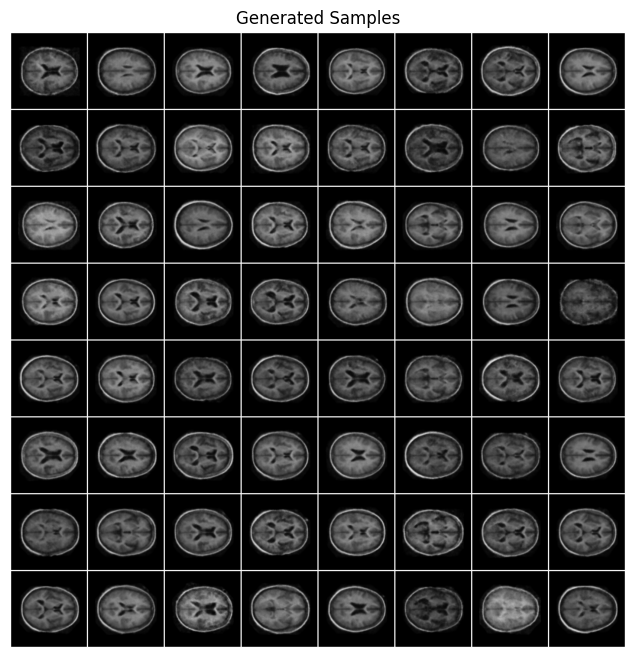

In [ ]:
@torch.no_grad()
def visualize_manifold(model, device, out_dir, z_dim=8):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    model.eval()
    if z_dim == 2:
        # Decode a regular grid in latent space
        grid_x = grid_y = 20
        xs = torch.linspace(-3, 3, grid_x)
        ys = torch.linspace(-3, 3, grid_y)
        imgs = []
        for j in ys:
            row = []
            for i in xs:
                z = torch.tensor([[i, j]], device=device, dtype=torch.float32)
                with torch.amp.autocast('cuda'):
                    logit = model.dec(z)
                    img = torch.sigmoid(logit)
                row.append(img)
            imgs.append(torch.cat(row, dim=0))
        manifold = torch.cat(imgs, dim=0)
        vutils.save_image(manifold, f"{out_dir}/manifold_2d.png", nrow=grid_x)
    else:
        if umap is None:
            print("UMAP not installed; skip latent embedding plot.")
            return
        # Create synthetic latent samples and project to 2D for visualization
        zs = torch.randn(2048, z_dim, device=device)
        emb = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="euclidean").fit_transform(zs.detach().cpu().numpy())
        # Save a simple scatter as npy (plotting can be done offline to keep this script minimal)
        np.save(f"{out_dir}/umap_latent.npy", emb)
        # Additionally, tile a few decoded samples and display them
        with torch.amp.autocast('cuda'):
            x_logits = model.dec(zs[:64])
            x = torch.sigmoid(x_logits)

        # Display the generated samples using matplotlib
        import matplotlib.pyplot as plt
        import torchvision.transforms.functional as F
        grid = vutils.make_grid(x, nrow=8, pad_value=1.0)
        plt.figure(figsize=(8, 8))
        plt.imshow(F.to_pil_image(grid))
        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

visualize_manifold(model, device, OUT_DIR, z_dim=z_dim)